## Database setup and statistical analysis


<div class="alert alert-block alert-warning"><b>Example:</b>NOTE: Tables 0:2 are required for querying spacial data and converting between coordinate systems. Do not modify or remove. Origin, FEMA_NRI, see readme for more information.</div>





In [72]:
# import libraries
# NOTE: global_vars should be edited to include local paths and credentials before use.
import ignore.global_vars as gv
import db_tools as dbt
import pandas as pd
import sqlalchemy
import sys
from IPython.display import display, HTML
from scipy import stats
from scipy.stats import poisson, nbinom, weibull_min, gamma, kstest
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
import plotly.graph_objects as go
from shapely import wkt
import os
import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic



In [2]:
# NOTE: Set to True if a full rebuild is required, set to False to skip table builds. Search 'REBUILD_TABLE' to see which sections are effected.
REBUILD = False

In [3]:
# open connection and get table names
table_names = dbt.query("SELECT table_name FROM information_schema.tables WHERE table_schema='public'")
print(table_names)


Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 12 rows
                             table_name
0                     census_resilience
1                     geography_columns
2                      geometry_columns
3                       spatial_ref_sys
4              POISSON_FREQUENCY_PARAMS
5               nri_shape_census_tracts
6                 disaster_risk_spatial
7              noaa_stormevents_ftp_all
8                   NOAA_STORM_EPISODES
9        disaster_risk_counties_spatial
10  disaster_risk_counties_event_counts
11                    NOAA_STORM_EVENTS


### Fitting Poisson distributions to historical disaster event counts ###


Poission process was chosen for disaster occurence due to:
- Right-tail skewed distribution
- Data is random
- Data is discrete
- Data is time series 



$$P(N_{i,t} = k) = \frac{\lambda_i^k e^{-\lambda_i}}{k!}$$

Where:  
$N_{i,t}$ = number of disaster episodes in county $i$ during year $t$  
$k$ = observed count (0, 1, 2, 3, ...)  
$\lambda_i$ = county-specific rate parameter (average annual episodes)  
$e$ = Euler's number (≈ 2.718)  
$k!$ = factorial of $k$  

$$N_{i,t} \sim \text{P}(\lambda_i)$$

Where:  
$N_{i,t}$ = number of disaster episodes in county $i$ during year $t$  
$\lambda_i$ = county-specific average annual episode rate  


---

\begin{align}
N_i &\sim \text{Poisson}(\lambda_i) \quad \text{[Frequency from NOAA]} \\
Y_{i,j} &\sim F_i(\theta_i) \quad \text{[Severity from Census/NOAA]} \\
S_i &= \sum_{j=1}^{N_i} Y_{i,j} \quad \text{[Total Risk]}
\end{align}

Where:
- N ~ Poisson(λ)           [Number of events from NOAA]
- Yi ~ Severity Distribution [Potential impact per event from Census data as vunerability]
- λ = NOAA historical event frequency
- Yi = f(population, vulnerability, demographics)

In [4]:
geography_columns = dbt.query("SELECT * FROM geography_columns")


Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 0 rows


In [5]:
# Load the NOAA data into a DataFrame for analysis
df_noaa = dbt.query("SELECT * FROM \"NOAA_STORM_EPISODES\" ORDER BY county_fips, year")


Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 107094 rows


In [6]:
# Basic data exploration of NOAA episodes
print("=== NOAA EPISODES DATA EXPLORATION ===")
print(f"DataFrame shape: {df_noaa.shape}")
print(f"Columns: {list(df_noaa.columns)}")
print(f"Data types:")
print(df_noaa.dtypes)

print(f"\n=== BASIC STATISTICS ===")
print(f"Year range: {df_noaa['year'].min()} - {df_noaa['year'].max()}")
print(f"Unique counties: {df_noaa['county_fips'].nunique()}")
print(f"Total county-year records: {len(df_noaa)}")
print(f"Event count statistics:")
print(df_noaa['event_count'].describe())

=== NOAA EPISODES DATA EXPLORATION ===
DataFrame shape: (107094, 9)
Columns: ['county_fips', 'year', 'event_count', 'total_deaths_direct', 'total_deaths_indirect', 'total_injuries_direct', 'total_injuries_indirect', 'event_types', 'first_event_date']
Data types:
county_fips                        object
year                                int64
event_count                         int64
total_deaths_direct                 int64
total_deaths_indirect               int64
total_injuries_direct               int64
total_injuries_indirect             int64
event_types                        object
first_event_date           datetime64[ns]
dtype: object

=== BASIC STATISTICS ===
Year range: 1999 - 2024
Unique counties: 4119
Total county-year records: 107094
Event count statistics:
count    107094.000000
mean          0.206921
std           0.658732
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          29.000000
Name: event_count, dtype: float

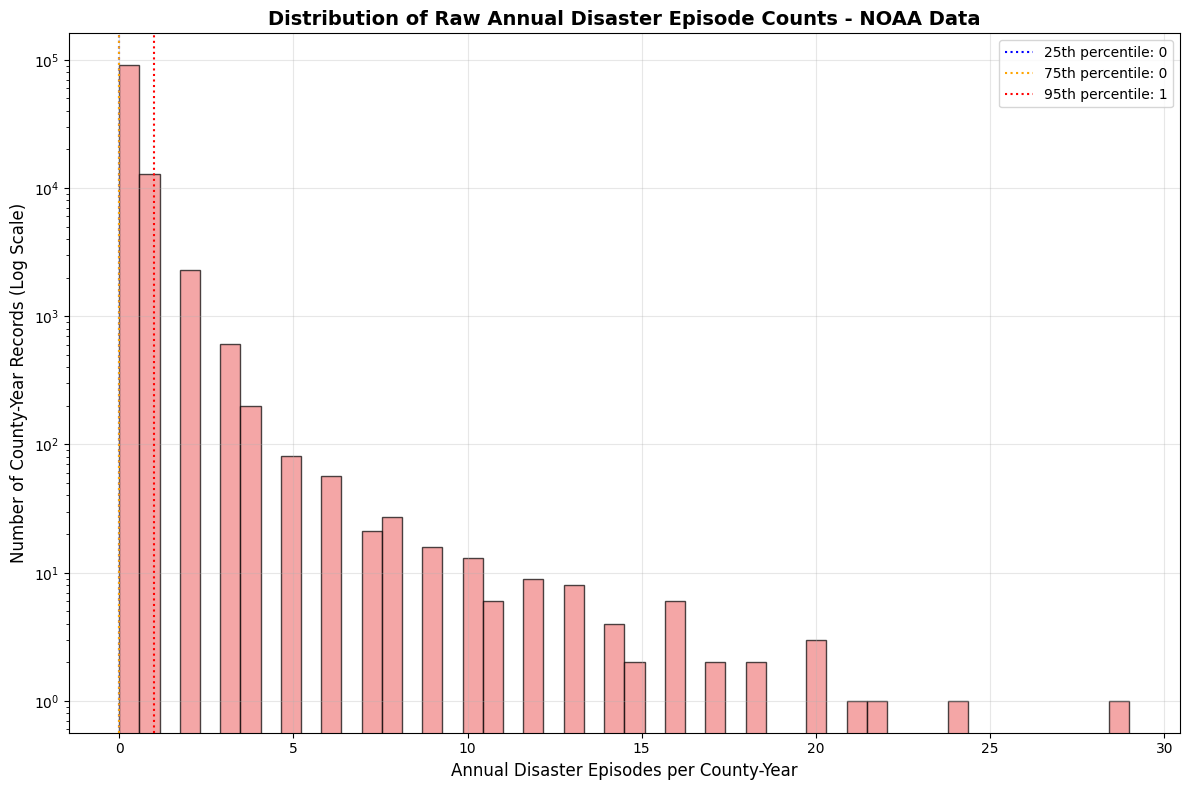

In [7]:
# Create histogram of raw event counts with log scale for distribution analysis
plt.figure(figsize=(12, 8))
plt.hist(df_noaa['event_count'], bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
plt.xlabel('Annual Disaster Episodes per County-Year', fontsize=12)
plt.ylabel('Number of County-Year Records (Log Scale)', fontsize=12)
plt.title('Distribution of Raw Annual Disaster Episode Counts - NOAA Data', fontsize=14, fontweight='bold')
plt.yscale('log')

# Add percentiles to help interpretation with log scale
raw_counts = df_noaa['event_count']
p25_raw = raw_counts.quantile(0.25)
p75_raw = raw_counts.quantile(0.75)
p95_raw = raw_counts.quantile(0.95)

plt.axvline(p25_raw, color='blue', linestyle=':', label=f'25th percentile: {p25_raw:.0f}')
plt.axvline(p75_raw, color='orange', linestyle=':', label=f'75th percentile: {p75_raw:.0f}')
plt.axvline(p95_raw, color='red', linestyle=':', label=f'95th percentile: {p95_raw:.0f}')

plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# get summary statistics for each county. Group by county_fips
county_lambdas = df_noaa.groupby('county_fips').agg({
    'event_count': ['mean', 'var', 'std', 'count', 'sum'],
    'year': ['min', 'max']
}).round(4)

# Flatten column names
county_lambdas.columns = ['_'.join(col).strip() for col in county_lambdas.columns]
county_lambdas = county_lambdas.reset_index()

# Rename for clarity
county_lambdas.rename(columns={
    'event_count_mean': 'lambda_hat',
    'event_count_var': 'variance', 
    'event_count_std': 'std_dev',
    'event_count_count': 'years_observed',
    'event_count_sum': 'total_events',
    'year_min': 'first_year',
    'year_max': 'last_year'
}, inplace=True)

# Calculate overdispersion ratio (variance/mean)
county_lambdas['overdispersion_ratio'] = np.where(
    county_lambdas['lambda_hat'] > 0,
    county_lambdas['variance'] / county_lambdas['lambda_hat'],
    np.nan
)

# Add these lines to see output:
print(f"Processed {len(county_lambdas)} counties")
print(f"Lambda statistics:")
print(county_lambdas["lambda_hat"].describe())
print("\nFirst few rows:")
print(county_lambdas.head())

Processed 4119 counties
Lambda statistics:
count    4119.000000
mean        0.206925
std         0.330591
min         0.038500
25%         0.076900
50%         0.115400
75%         0.230800
max         8.269200
Name: lambda_hat, dtype: float64

First few rows:
  county_fips  lambda_hat  variance  std_dev  years_observed  total_events  \
0       01001      0.5769    0.4138   0.6433              26            15   
1       01002      0.2692    0.2846   0.5335              26             7   
2       01003      1.2308    1.6246   1.2746              26            32   
3       01004      0.0769    0.0738   0.2717              26             2   
4       01005      0.3077    0.3815   0.6177              26             8   

   first_year  last_year  overdispersion_ratio  
0        1999       2024              0.717282  
1        1999       2024              1.057207  
2        1999       2024              1.319955  
3        1999       2024              0.959688  
4        1999       2024 

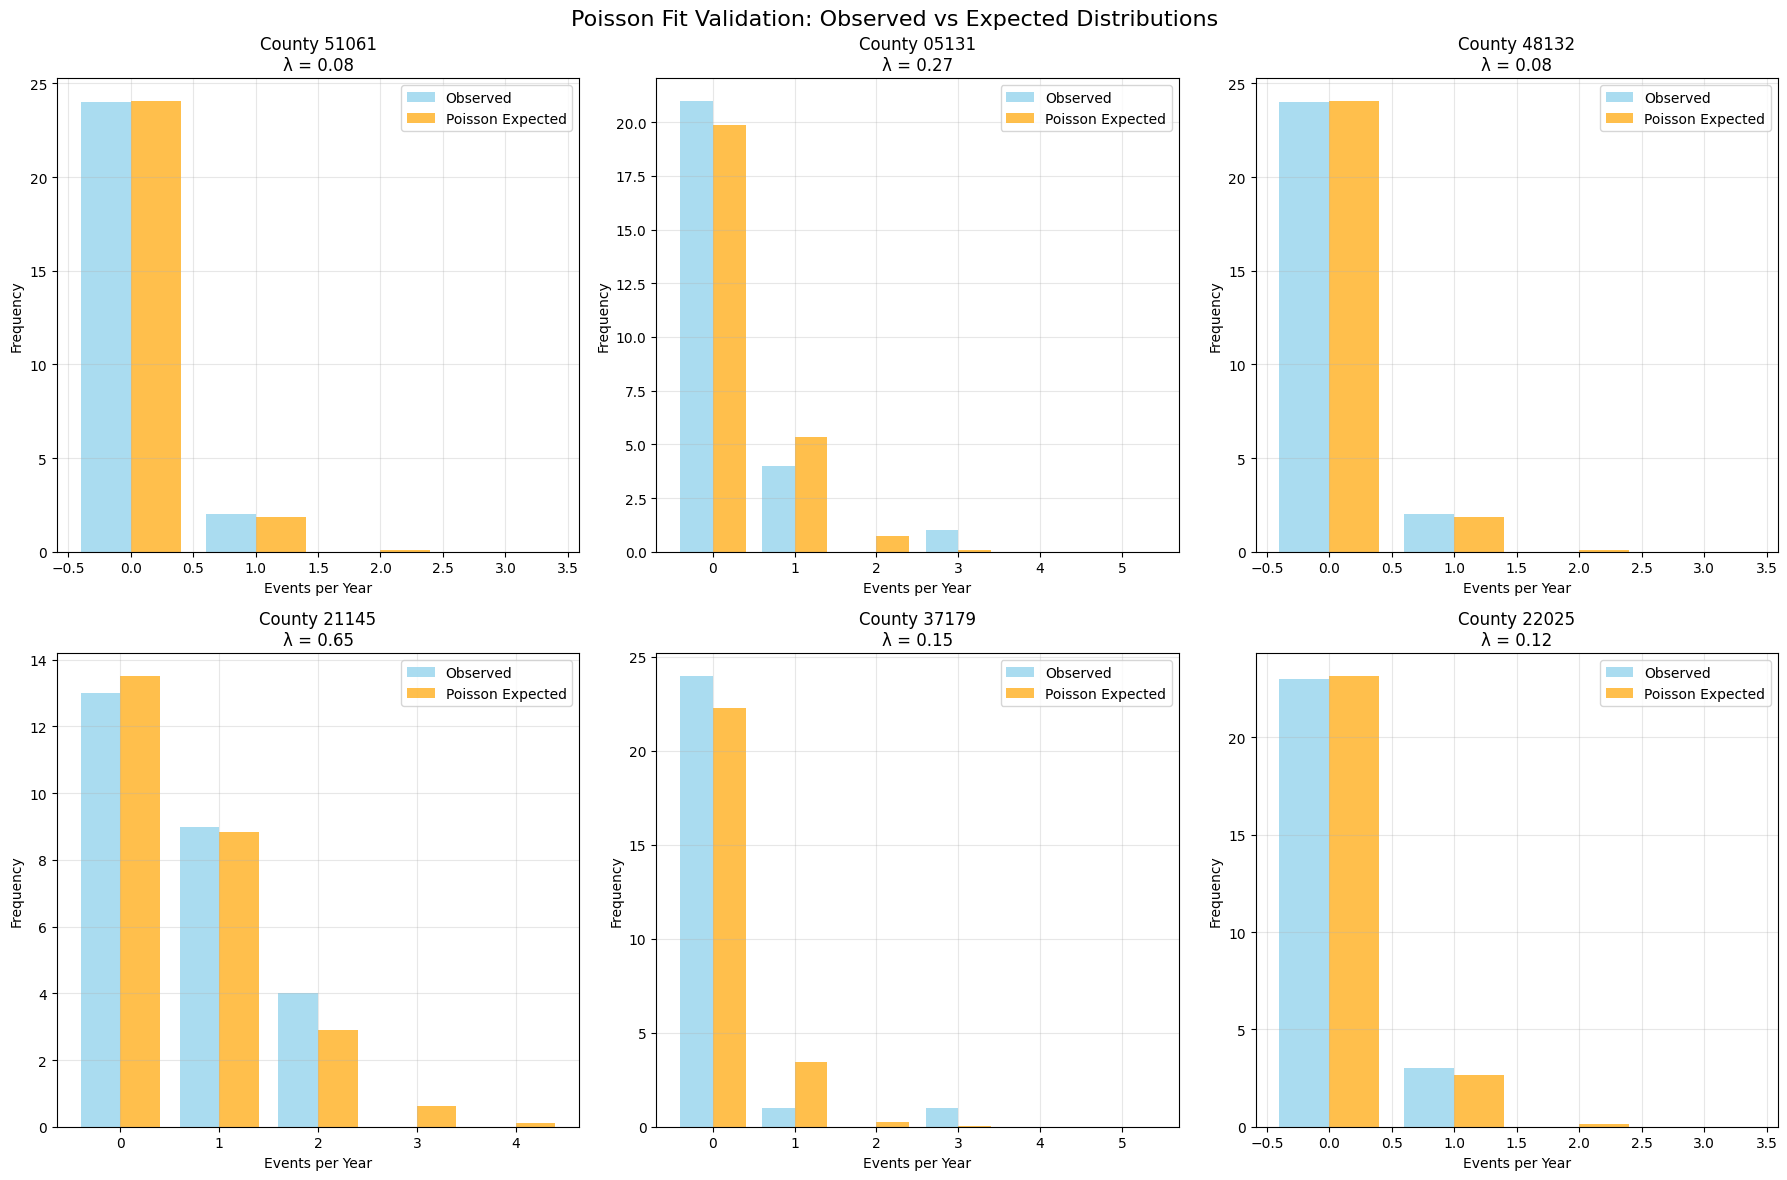

In [9]:
# Sample 6 counties for fit validation
sample_counties = county_lambdas.sample(6, random_state=36)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (_, county) in enumerate(sample_counties.iterrows()):
    county_fips = county['county_fips']
    lambda_est = county['lambda_hat']

    county_data = df_noaa[df_noaa['county_fips'] == county_fips]['event_count']
    max_events = int(county_data.max()) + 2
    x_vals = range(0, max_events + 1)
    theoretical_probs = [poisson.pmf(k, lambda_est) for k in x_vals]
    theoretical_counts = [p * len(county_data) for p in theoretical_probs]
    actual_counts = [sum(county_data == k) for k in x_vals]
    axes[i].bar([x - 0.2 for x in x_vals], actual_counts, width=0.4, 
                label='Observed', alpha=0.7, color='skyblue')
    axes[i].bar([x + 0.2 for x in x_vals], theoretical_counts, width=0.4, 
                label='Poisson Expected', alpha=0.7, color='orange')
    
    axes[i].set_title(f'County {county_fips}\nλ = {lambda_est:.2f}')
    axes[i].set_xlabel('Events per Year')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.suptitle('Poisson Fit Validation: Observed vs Expected Distributions', fontsize=16)
plt.tight_layout()
plt.show()

In [10]:
# make a dataframe of the poisson risk parameters
poisson_risk_params = county_lambdas[['county_fips', 'lambda_hat', 'years_observed', 'total_events']].copy()

# Add confidence intervals for lambda estimates NOTE: not yet implemented, generating these in case we need them
poisson_risk_params['lambda_se'] = np.sqrt(poisson_risk_params['lambda_hat'] / poisson_risk_params['years_observed'])
poisson_risk_params['lambda_ci_lower'] = poisson_risk_params['lambda_hat'] - 1.96 * poisson_risk_params['lambda_se']
poisson_risk_params['lambda_ci_upper'] = poisson_risk_params['lambda_hat'] + 1.96 * poisson_risk_params['lambda_se']

# set any negative lower CI bounds to zero
poisson_risk_params['lambda_ci_lower'] = np.maximum(0, poisson_risk_params['lambda_ci_lower'])

# calculate the probability of at least one event in a year
# P(≥1 disaster) = 1 - e^(-λ)
poisson_risk_params["prob_at_least_one_event"] = 1 - np.exp(
    -poisson_risk_params["lambda_hat"]
)

In [ ]:
# Create spatial database table for QGIS access using the reusable function
if REBUILD:
    # Define the columns we want to include in the spatial data
    risk_columns = [
        "county_fips",
        "lambda_hat",
        "total_events",
        "years_observed",
        "lambda_ci_lower",
        "lambda_ci_upper",
        "prob_at_least_one_event"
    ]
    
    try:
        # Use the reusable function to prepare spatial data
        lambda_map_clean, db_data = dbt.prepare_spatial_data_for_qgis(
            dataframe=poisson_risk_params,
            geometry_source='nri_shapefile',
            data_columns=risk_columns,
            county_fips_col='county_fips',
            impute_missing=True,
            add_rounded_cols=True
        )
        
        # Save to database (you can implement the load function)
        print("Saving spatial data to database...")
        dbt.load_data(db_data, "disaster_risk_spatial", if_exists="replace")
        
        # Create spatial table with PostGIS geometry
        print("Creating PostGIS spatial table...")
        spatial_table_sql = """
        DROP TABLE IF EXISTS disaster_risk_counties_spatial;

        CREATE TABLE disaster_risk_counties_spatial AS
        SELECT 
            county_fips,
            lambda_hat,
            lambda_rounded,
            prob_at_least_one_event,
            total_events,
            years_observed,
            lambda_ci_lower,
            lambda_ci_upper,
            ST_GeomFromText(geometry_wkt, 4326) as geometry
        FROM disaster_risk_spatial;

        -- Add spatial index for performance
        CREATE INDEX idx_disaster_risk_counties_spatial_geom 
        ON disaster_risk_counties_spatial USING GIST (geometry);

        -- Add primary key
        ALTER TABLE disaster_risk_counties_spatial 
        ADD CONSTRAINT pk_disaster_risk_counties_spatial PRIMARY KEY (county_fips);
        """
        
        dbt.execute_sql(spatial_table_sql)
        print("Spatial database table created: disaster_risk_counties_spatial")
        
    except Exception as e:
        print(f"Error creating spatial data: {e}")
        print("No geographic data available")
else: 
    print("Skip rebuilding table")

Skip rebuilding table


next steps
Severity modeling using census resilience data
Compound model integration (frequency × severity)
Risk scenario simulation
Geographic risk mapping

In [12]:
# create table for disaster counts by county
if REBUILD:
    event_types_sql = """
    SELECT DISTINCT "EVENT_TYPE" 
    FROM "NOAA_STORM_EVENTS" 
    WHERE ("INJURIES_DIRECT" > 0 OR "DEATHS_DIRECT" > 0)
    ORDER BY "EVENT_TYPE";
    """

    event_types = dbt.query(event_types_sql)
    # Build dynamic pivot columns
    pivot_columns = []
    for event_type in event_types["EVENT_TYPE"]:
        safe_name = (
            event_type.lower()
            .replace(" ", "_")
            .replace("-", "_")
            .replace(".", "_")
            .replace("/", "_")
            .replace("(", "")
            .replace(")", "")
        )
        pivot_columns.append(
            f"SUM(CASE WHEN \"EVENT_TYPE\" = '{event_type}' THEN event_count ELSE 0 END) as {safe_name}_severe"
        )

    pivot_sql = f"""
    WITH severe_events AS (
        SELECT 
            "CO_FIPS" as county_fips,
            "EVENT_TYPE",
            COUNT(*) as event_count
        FROM "NOAA_STORM_EVENTS" 
        WHERE ("INJURIES_DIRECT" > 0 OR "DEATHS_DIRECT" > 0)
        AND "CO_FIPS" IS NOT NULL
        GROUP BY "CO_FIPS", "EVENT_TYPE"
    ),
    pivoted_events AS (
        SELECT 
            county_fips,
            {",".join(pivot_columns)},
            COUNT(DISTINCT "EVENT_TYPE") as severe_event_types,
            SUM(event_count) as total_severe_events
        FROM severe_events
        GROUP BY county_fips
    )
    SELECT 
        s.*,
        p.{",p.".join([col.split(" as ")[1] for col in pivot_columns])},
        p.severe_event_types,
        p.total_severe_events
    FROM disaster_risk_counties_spatial s
    LEFT JOIN pivoted_events p ON s.county_fips = p.county_fips
    ORDER BY s.county_fips;
    """

    pivot_result = dbt.query(pivot_sql)
else:
    print("Skipped table rebuild")

Skipped table rebuild


In [ ]:
# Create table with event counts per county
# This table is used for troubleshooting and future functionality
# or for county level historical disaster exploration
if REBUILD:
    create_enhanced_table_sql = f"""
    DROP TABLE IF EXISTS disaster_risk_counties_event_counts;

    CREATE TABLE disaster_risk_counties_event_counts AS
    {pivot_sql};

    -- Add indexes
    CREATE INDEX idx_disaster_risk_event_counts_geom ON disaster_risk_counties_event_counts USING GIST (geometry);
    ALTER TABLE disaster_risk_counties_event_counts ADD CONSTRAINT pk_disaster_risk_event_counts PRIMARY KEY (county_fips);
    """

    dbt.execute_sql(create_enhanced_table_sql)
    print("Enhanced table created: disaster_risk_counties_event_counts")

else: 
    print("table build skipped")


table build skipped


# Severity component


Candidates for deaths/injuries
lognormal
gamma
weibull

lognormal eliminated due to graph above


deaths 1 injurys .1 vunerabiliy rate .x

d + i + v

machine leanring thingy that iterates through combos of vars. 


census 
POPUNI
PRED12_PE
PRED3_PE

In [14]:
# Load tables from database
df_noaa_episodes = dbt.query('SELECT * FROM "NOAA_STORM_EPISODES"')
df_noaa_events = dbt.query('SELECT * FROM "NOAA_STORM_EVENTS"')
df_census = dbt.query('SELECT * FROM "census_resilience"')

Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 107094 rows
Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 1500308 rows
Created SQLAlchemy engine for disaster_db
Query executed successfully, returned 3144 rows


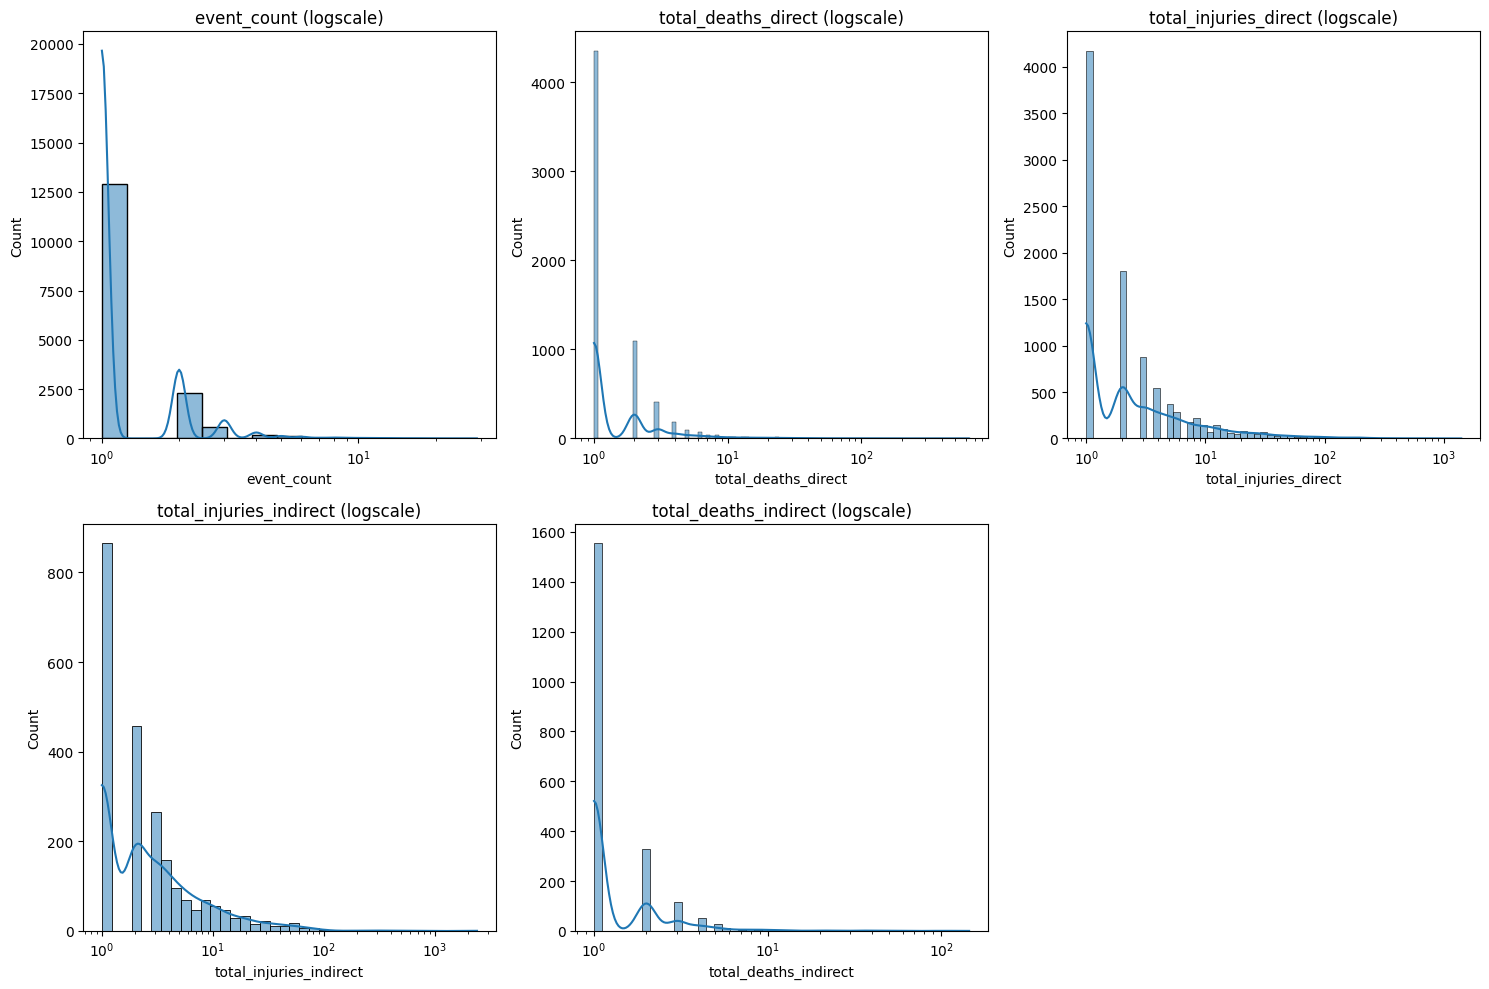

In [15]:
# Plot variables to examine shape of raw data
plot_vars = [
    "event_count",
    "total_deaths_direct",
    "total_injuries_direct",
    "total_injuries_indirect",
    "total_deaths_indirect",
]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
pick_vars = [var for var in plot_vars if var in df_noaa_episodes.columns]
for i, var in enumerate(pick_vars):
    if i < len(axes):
        data = df_noaa_episodes[var]
        data_non = data[data > 0]

        if len(data_non) > 0:
            sns.histplot(data_non, kde=True, log_scale=True, ax=axes[i])
            axes[i].set_title(f"{var} (logscale)")
            axes[i].set_xlabel(var)

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [16]:
# Generate casualty rate and merge noaa_episodes with census on county_fips
df_noaa_episodes["casualties"] = (
    df_noaa_episodes["total_injuries_direct"]
    + df_noaa_episodes["total_deaths_direct"]
    + df_noaa_episodes["total_injuries_indirect"]
    + df_noaa_episodes["total_deaths_indirect"]
)
noaa_episodes_census_merge = df_noaa_episodes.merge(
    df_census, left_on="county_fips", right_on="County_fips"
)
noaa_episodes_census_merge["casualty_rate"] = (
    noaa_episodes_census_merge["casualties"]
    / noaa_episodes_census_merge["POPUNI"]
    * 1000
)
noaa_census = noaa_episodes_census_merge.copy()
noaa_census[noaa_census["casualties"] > 1].describe()

,year,event_count,total_deaths_direct,total_deaths_indirect,total_injuries_direct,total_injuries_indirect,first_event_date,casualties,POPUNI,PRED12_PE,PRED3_PE,casualty_rate
count,6721.000000,6721.000000,6721.000000,6721.000000,6721.000000,6721.000000,6721,6721.000000,6.721000e+03,6721.000000,6721.000000,6721.000000
mean,2010.313049,1.540098,1.056837,0.185538,7.224223,1.352626,2010-09-26 07:14:17.550959616,9.819223,2.822420e+05,44.052379,22.394188,0.538748
min,1999.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1999-01-01 00:00:00,2.000000,4.300000e+01,27.510000,9.370000,0.000209
25%,2004.000000,1.000000,0.000000,0.000000,1.000000,0.000000,2004-07-12 00:00:00,2.000000,1.954500e+04,41.310000,18.740000,0.016540
50%,2010.000000,1.000000,0.000000,0.000000,2.000000,0.000000,2010-05-02 00:00:00,3.000000,6.018300e+04,43.620000,21.890000,0.068080
75%,2016.000000,2.000000,1.000000,0.000000,5.000000,0.000000,2016-07-03 00:00:00,7.000000,2.303150e+05,46.560000,25.410000,0.229663
max,2024.000000,21.000000,160.000000,12.000000,1404.000000,2400.000000,2024-12-29 00:00:00,2409.000000,9.580929e+06,66.460000,48.860000,254.347826
std,7.297090,1.056404,3.591332,0.671667,33.712570,29.980992,NaN,46.342503,6.608666e+05,3.967798,5.349698,4.547839


In [17]:
# combine vunerabiliyt predictors with simple addition and create intensity rate.
# Multiplicative was chose for amplification effect of casualties on a vunerable population
# Intensity = casualty rate (per 1000) * 1 + (vunerability_rate /100)
noaa_census["vunerability_rate"] = noaa_census["PRED12_PE"] + noaa_census["PRED3_PE"]
noaa_census["intensity"] = noaa_census["casualty_rate"] * (
    1 + (noaa_census["vunerability_rate"] / 100)
)
noaa_census.describe()

,year,event_count,total_deaths_direct,total_deaths_indirect,total_injuries_direct,total_injuries_indirect,first_event_date,casualties,POPUNI,PRED12_PE,PRED3_PE,casualty_rate,vunerability_rate,intensity
count,70980.000000,70980.000000,70980.000000,70980.000000,70980.000000,70980.000000,12019,70980.000000,7.098000e+04,70980.000000,70980.000000,70980.000000,70980.000000,70980.000000
mean,2011.500000,0.220471,0.125359,0.023500,0.723514,0.132037,2011-01-08 03:49:47.769364992,1.004410,1.168165e+05,43.656934,23.027974,0.055788,66.684908,0.095199
min,1999.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1999-01-01 00:00:00,0.000000,4.300000e+01,27.510000,9.370000,0.000000,40.780000,0.000000
25%,2005.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2004-10-03 12:00:00,0.000000,1.282800e+04,40.950000,19.090000,0.000000,61.850000,0.000000
50%,2011.500000,0.000000,0.000000,0.000000,0.000000,0.000000,2010-07-26 00:00:00,0.000000,2.948200e+04,43.205000,22.545000,0.000000,66.480000,0.000000
75%,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017-01-20 00:00:00,0.000000,7.943800e+04,46.290000,26.280000,0.000000,71.500000,0.000000
max,2024.000000,21.000000,160.000000,12.000000,1404.000000,2400.000000,2024-12-31 00:00:00,2409.000000,9.580929e+06,66.460000,48.860000,254.347826,89.580000,443.023043
std,7.500053,0.596897,1.156041,0.226606,10.585862,9.233641,NaN,14.543867,3.508919e+05,4.222459,5.595036,1.412217,7.000161,2.453534


In [18]:
# Check df sizes, suspect missing data
print(df_noaa_episodes.shape)
print(noaa_census.shape)

(107094, 10)
(70980, 20)


Signifiant difference in dataframes, over 30% of data is missing from the census data for county_fips. Strategy is to use state averages of vunerability to impute missing data. Justification, casualty rate is the primary componenet of severity, vunerability can be infered. 

In [20]:
# Calculate state averages for vulnerability imputation
df_census["state_fips"] = df_census["County_fips"].str[:2]
state_vulnerability_avg = df_census.groupby("state_fips")[
    ["PRED12_PE", "PRED3_PE"]
].mean()

# Perform left join to keep all NOAA data. strip state FIPS for averaging later
noaa_census_full = df_noaa_episodes.merge(
    df_census, left_on="county_fips", right_on="County_fips", how="left"
)
noaa_census_full["state_fips"] = noaa_census_full["county_fips"].str[:2]
noaa_census_full.shape

(107094, 18)

In [21]:
# Impute missing vulnerability data using state averages
# First, create a mapping of state averages
state_avg_mapping = state_vulnerability_avg.to_dict()


# Function to impute missing values
def impute_vulnerability(row, vulnerability_col, state_col="state_fips"):
    if pd.isna(row[vulnerability_col]):
        state = row[state_col]
        if state in state_avg_mapping[vulnerability_col]:
            return state_avg_mapping[vulnerability_col][state]
        else:
            # If state not in mapping, use overall average
            return df_census[vulnerability_col].mean()
    return row[vulnerability_col]


# Apply imputation
noaa_census_full["PRED12_PE_imputed"] = noaa_census_full.apply(
    lambda row: impute_vulnerability(row, "PRED12_PE"), axis=1
)
noaa_census_full["PRED3_PE_imputed"] = noaa_census_full.apply(
    lambda row: impute_vulnerability(row, "PRED3_PE"), axis=1
)


In [22]:
# Recalculate intensity with imputed vulnerability data
# Use POPUNI from census data, impute if missing using national average
national_avg_pop = df_census["POPUNI"].mean()
noaa_census_full["POPUNI_imputed"] = noaa_census_full["POPUNI"].fillna(national_avg_pop)

# Calculate casualties, casualty rate, vulnerability rate, and intensity
noaa_census_full["casualties"] = (
    noaa_census_full["total_injuries_direct"]
    + noaa_census_full["total_deaths_direct"]
    + noaa_census_full["total_injuries_indirect"]
    + noaa_census_full["total_deaths_indirect"]
)

noaa_census_full["casualty_rate"] = (
    noaa_census_full["casualties"] / noaa_census_full["POPUNI_imputed"] * 1000
)
noaa_census_full["vulnerability_rate"] = (
    noaa_census_full["PRED12_PE_imputed"] + noaa_census_full["PRED3_PE_imputed"]
)
noaa_census_full["intensity"] = noaa_census_full["casualty_rate"] * (
    1 + (noaa_census_full["vulnerability_rate"] / 100)
)

print("Dataset summary after imputation:")
print(f"Total rows: {len(noaa_census_full):,}")
print(f"Rows with casualties > 0: {(noaa_census_full['casualties'] > 0).sum():,}")
print(f"Rows with intensity > 0: {(noaa_census_full['intensity'] > 0).sum():,}")

noaa_census_full[
    ["casualties", "casualty_rate", "vulnerability_rate", "intensity"]
].describe()


Dataset summary after imputation:
Total rows: 107,094
Rows with casualties > 0: 16,249
Rows with intensity > 0: 16,249


,casualties,casualty_rate,vulnerability_rate,intensity
count,107094.000000,107094.000000,107094.000000,107094.000000
mean,0.958821,0.039767,67.095116,0.067804
std,13.448128,1.151525,6.409072,2.000462
min,0.000000,0.000000,40.780000,0.000000
25%,0.000000,0.000000,62.591667,0.000000
50%,0.000000,0.000000,66.980000,0.000000
75%,0.000000,0.000000,71.783333,0.000000
max,2409.000000,254.347826,89.580000,443.023043


In [25]:
# Filter for events with intensity > 0 for distribution fitting
intensity_data = noaa_census_full[noaa_census_full["intensity"] > 0]["intensity"]

In [26]:
# Fit distribution to Wiebull using .fit MLE
weibull_params = weibull_min.fit(intensity_data, floc=0)
weibull_shape, weibull_loc, weibull_scale = weibull_params
print("Fitted Weibull Parameters:")
print(f"Shape (k): {weibull_shape:.6f}")
print(f"Scale (λ): {weibull_scale:.6f}")
print(f"Location: {weibull_loc:.6f}")

Fitted Weibull Parameters:
Shape (k): 0.511866
Scale (λ): 0.133941
Location: 0.000000


In [29]:
# Used scipy weibull_min for modeling "min extreme value" of derived "intensity"
# shape: k parameter describing skewedness
# scale: lambda parameter for spread
# location: shift parameter, locked at 0 for this implementation.
severity_distribution = {
    'distribution':'weibull_min',
    'shape':weibull_shape,
    'scale':weibull_scale,
    'location':weibull_loc
}

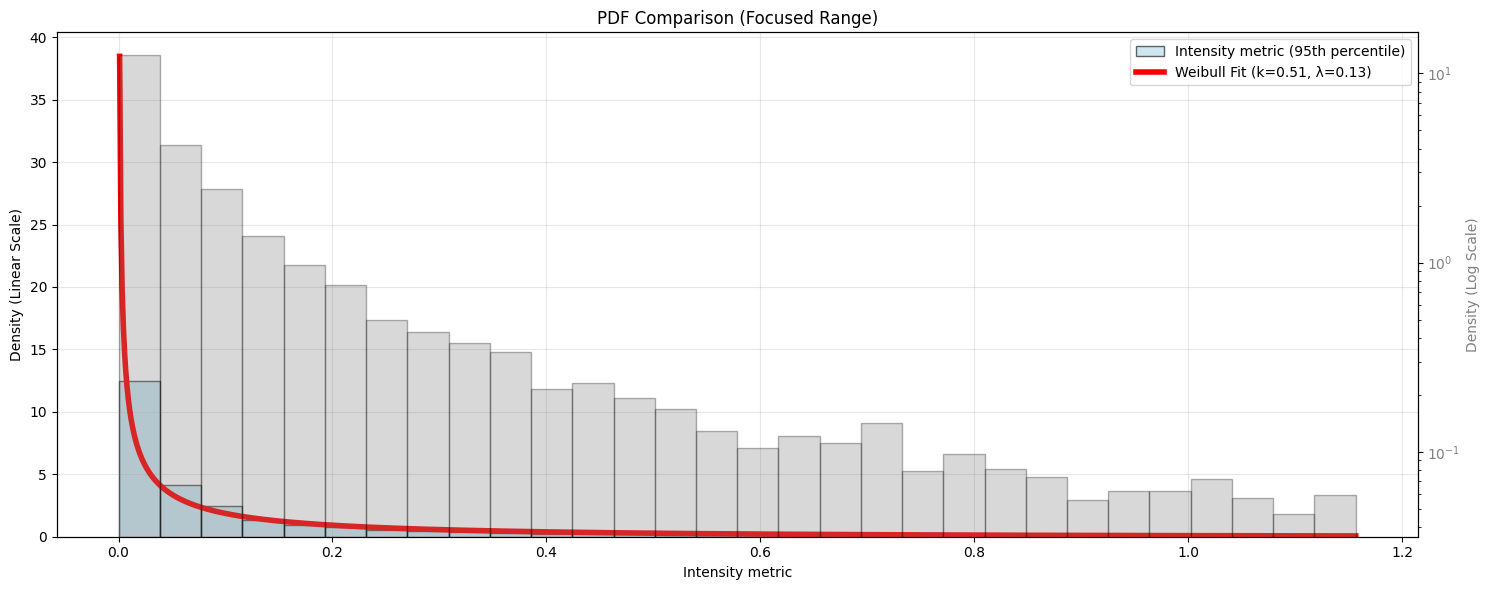

In [28]:
# Create right skew focused histogram to compare theoretical Weibull PDF fit to intensity metric histogram.
fig, ax = plt.subplots(1, figsize=(15, 6))
x_range = np.linspace(0.001, np.percentile(intensity_data, 95), 1000)
weibull_pdf = weibull_min.pdf(x_range, *weibull_params)
ax.hist(
    intensity_data[intensity_data <= np.percentile(intensity_data, 95)],
    bins=30,
    density=True,
    alpha=0.6,
    color="lightblue",
    label="Intensity metric (95th percentile)",
    edgecolor="black",
)
ax.plot(
    x_range,
    weibull_pdf,
    "r-",
    lw=4,
    label=f"Weibull Fit (k={weibull_shape:.2f}, λ={weibull_scale:.2f})",
)
ax_twin = ax.twinx()
ax_twin.hist(
    intensity_data[intensity_data <= np.percentile(intensity_data, 95)],
    bins=30,
    density=True,
    alpha=0.3,
    color="gray",
    edgecolor="black",
)
ax_twin.set_yscale("log")
ax_twin.set_ylabel("Density (Log Scale)", color="gray")
ax_twin.tick_params(axis="y", labelcolor="gray")
ax.set_xlabel("Intensity metric")
ax.set_ylabel("Density (Linear Scale)")
ax.set_title("PDF Comparison (Focused Range)")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Setup compound model

In [30]:
def simulate_compound_poisson_risk(county_fips, n_simulations=10000):
    # Get county's λ (frequency)
    lambda_i = poisson_risk_params[poisson_risk_params["county_fips"] == county_fips][
        "lambda_hat"
    ].iloc[0]

    # Simulate total risk for each year
    total_risks = []
    for _ in range(n_simulations):
        # Step 1: Generate number of events N ~ Poisson(λ)
        n_events = np.random.poisson(lambda_i)

        # Step 2: Generate severity for each event Y ~ Weibull
        if n_events > 0:
            severities = weibull_min.rvs(
                weibull_shape, loc=weibull_loc, scale=weibull_scale, size=n_events
            )
            total_risk = np.sum(severities)
        else:
            total_risk = 0

        total_risks.append(total_risk)

    return np.array(total_risks)


In [32]:
poisson_risk_params.sample(2)

,county_fips,lambda_hat,years_observed,total_events,lambda_se,lambda_ci_lower,lambda_ci_upper,prob_at_least_one_event
978,17086,0.1923,26,5,0.086001,0.023738,0.360862,0.174941
1516,21187,0.1538,26,4,0.076912,0.003053,0.304547,0.142557


In [34]:
# For a specific county
risks = simulate_compound_poisson_risk("21187")  # example FIPS
risk_percentiles = np.percentile(risks, [50, 90, 95, 99])
expected_annual_loss = np.mean(risks)
print(expected_annual_loss)

0.04021753083283117


In [39]:
# Apply to all counties in your dataset
county_risks = {}
for county in tqdm.tqdm(poisson_risk_params["county_fips"]):
    county_risks[county] = simulate_compound_poisson_risk(county)

100%|██████████| 4119/4119 [02:26<00:00, 28.18it/s]


In [40]:
# Check structure
print(f"Type: {type(county_risks)}")
print(f"Number of counties: {len(county_risks)}")
print(f"Sample county risk array shape: {county_risks[list(county_risks.keys())[0]].shape}")

Type: <class 'dict'>
Number of counties: 4119
Sample county risk array shape: (10000,)


In [ ]:
# coordinates are EPSG:3857 but stored with wrong SRID
# transforming to WGS84
fix_coordinates_sql = """
DROP TABLE IF EXISTS disaster_risk_counties_spatial_corrected;
CREATE TABLE disaster_risk_counties_spatial_corrected AS
SELECT 
    county_fips,
    lambda_hat,
    lambda_rounded,
    prob_at_least_one_event,
    total_events,
    years_observed,
    lambda_ci_lower,
    lambda_ci_upper,
    ST_Transform(ST_SetSRID(geometry, 3857), 4326) as geometry
FROM disaster_risk_counties_spatial;

CREATE INDEX idx_disaster_risk_counties_spatial_corrected_geom 
ON disaster_risk_counties_spatial_corrected USING GIST (geometry);

ALTER TABLE disaster_risk_counties_spatial_corrected 
ADD CONSTRAINT pk_disaster_risk_counties_spatial_corrected PRIMARY KEY (county_fips);
"""

# extract county centroids and risk data with correctly formatted coordinates
dbt.execute_sql(fix_coordinates_sql)

county_geo_risk_query = """
SELECT 
    s.county_fips,
    ST_Y(ST_Centroid(s.geometry)) as latitude,
    ST_X(ST_Centroid(s.geometry)) as longitude,
    c.expected_annual_loss,
    c.var_95,
    s.lambda_hat
FROM disaster_risk_counties_spatial_corrected s
JOIN disaster_risk_clusters c ON s.county_fips = c.county_fips
WHERE s.geometry IS NOT NULL
ORDER BY s.county_fips
"""


In [ ]:
# load counties including geographic and risk data
county_data = dbt.query(county_geo_risk_query)
print(f"Loaded {len(county_data)} counties with geographic and risk data")

# Data validation and cleaning
print("Data validation:")
print(
    f"Latitude range: {county_data['latitude'].min():.3f} to {county_data['latitude'].max():.3f}"
)
print(
    f"Longitude range: {county_data['longitude'].min():.3f} to {county_data['longitude'].max():.3f}"
)
print(f"NULL values: {county_data.isnull().sum().sum()}")

# Filter out invalid coordinates
valid_coords = (
    (county_data["latitude"] >= -90)
    & (county_data["latitude"] <= 90)
    & (county_data["longitude"] >= -180)
    & (county_data["longitude"] <= 180)
    & county_data["latitude"].notna()
    & county_data["longitude"].notna()
)

county_data_clean = county_data[valid_coords].copy()
print(f"After cleaning: {len(county_data_clean)} counties with valid coordinates")


In [68]:
# Step 2: Geographic clustering for depot placement (pure geography)
geo_features = county_data_clean[["latitude", "longitude"]].values
geo_scaler = StandardScaler()
geo_features_scaled = geo_scaler.fit_transform(geo_features)

# Use fewer clusters for depot placement (6-8 is more realistic)
n_depots = 36
geo_kmeans = KMeans(n_clusters=n_depots, random_state=36, n_init=10)
county_data_clean["depot_service_area"] = geo_kmeans.fit_predict(geo_features_scaled)

# Step 3: Calculate depot locations (centroids of service areas)
depot_locations = []
for depot_id in range(n_depots):
    service_counties = county_data_clean[
        county_data_clean["depot_service_area"] == depot_id
    ]

    # Weighted centroid based on risk levels
    total_risk = service_counties["expected_annual_loss"].sum()
    if total_risk > 0:
        weighted_lat = (
            service_counties["latitude"] * service_counties["expected_annual_loss"]
        ).sum() / total_risk
        weighted_lon = (
            service_counties["longitude"] * service_counties["expected_annual_loss"]
        ).sum() / total_risk
    else:
        weighted_lat = service_counties["latitude"].mean()
        weighted_lon = service_counties["longitude"].mean()

    depot_locations.append(
        {
            "depot_id": depot_id,
            "latitude": weighted_lat,
            "longitude": weighted_lon,
            "counties_served": len(service_counties),
            "total_risk_served": service_counties["expected_annual_loss"].sum(),
            "avg_risk_per_county": service_counties["expected_annual_loss"].mean(),
        }
    )

depot_df = pd.DataFrame(depot_locations)
print("\nDepot Locations:")
print(depot_df)



Depot Locations:
    depot_id   latitude   longitude  counties_served  total_risk_served  \
0          0  39.570827  -76.582237              107           9.194128   
1          1  35.095194  -95.458084               84           5.102726   
2          2  43.540031  -98.833595               83           1.842020   
3          3  38.308003 -120.910729               54           4.438387   
4          4  34.995338  -79.815827               81           5.602943   
5          5  47.519446 -119.687146               40           1.510636   
6          6  41.145233  -84.522903              130           6.131760   
7          7  47.247524  -97.366550               53           1.800669   
8          8  35.892692  -85.277628              115           5.084284   
9          9  21.272246 -157.781258                5           0.758099   
10        10  30.909151  -90.302611               90           6.101864   
11        11  42.601316 -111.153999               39           1.841931   
12     

In [69]:
# Step 4: Calculate service area statistics with error handling
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points using geodesic distance with validation"""
    try:
        # Validate coordinates before calculation
        if any(pd.isna([lat1, lon1, lat2, lon2])):
            return np.nan
        if not (-90 <= lat1 <= 90 and -90 <= lat2 <= 90):
            return np.nan
        if not (-180 <= lon1 <= 180 and -180 <= lon2 <= 180):
            return np.nan

        return geodesic((lat1, lon1), (lat2, lon2)).kilometers
    except Exception as e:
        print(f"Distance calculation error: {e}")
        return np.nan


service_area_stats = []
for _, county in county_data_clean.iterrows():
    depot_id = county["depot_service_area"]
    depot_info = depot_df[depot_df["depot_id"] == depot_id].iloc[0]

    distance = calculate_distance(
        county["latitude"],
        county["longitude"],
        depot_info["latitude"],
        depot_info["longitude"],
    )

    service_area_stats.append(
        {
            "county_fips": county["county_fips"],
            "depot_id": depot_id,
            "distance_to_depot_km": distance,
            "county_risk": county["expected_annual_loss"],
        }
    )

service_stats_df = pd.DataFrame(service_area_stats)

# Remove rows with invalid distances
service_stats_df = service_stats_df.dropna(subset=["distance_to_depot_km"])
print(f"Valid distance calculations: {len(service_stats_df)}")


Valid distance calculations: 2738


In [70]:
# Step 5: Analyze depot performance
depot_performance = (
    service_stats_df.groupby("depot_id")
    .agg(
        {
            "distance_to_depot_km": ["mean", "max", "std"],
            "county_risk": ["sum", "mean", "count"],
            "county_fips": "count",
        }
    )
    .round(2)
)

depot_performance.columns = ["_".join(col).strip() for col in depot_performance.columns]
depot_performance = depot_performance.reset_index()

print("\nDepot Performance Analysis:")
print(depot_performance)

# Step 6: Save depot results to database
print("\nSaving depot placement results to database...")

# Save depot locations
dbt.load_data(depot_df, "strategic_depot_locations", if_exists="replace")

# Save county assignments
county_assignments = county_data_clean[["county_fips", "depot_service_area"]].copy()
county_assignments.rename(columns={"depot_service_area": "depot_id"}, inplace=True)
dbt.load_data(county_assignments, "county_depot_assignments", if_exists="replace")

# Save detailed service statistics
dbt.load_data(service_stats_df, "depot_service_statistics", if_exists="replace")

# Create spatial table for QGIS mapping
create_depot_spatial_sql = """
-- Create depot points table for QGIS
DROP TABLE IF EXISTS strategic_depot_points;

CREATE TABLE strategic_depot_points AS
SELECT 
    depot_id,
    latitude,
    longitude,
    counties_served,
    total_risk_served,
    avg_risk_per_county,
    ST_SetSRID(ST_MakePoint(longitude, latitude), 4326) as geometry
FROM strategic_depot_locations;

-- Add spatial index
CREATE INDEX idx_strategic_depot_points_geom 
ON strategic_depot_points USING GIST (geometry);

-- Create county service areas table for QGIS
DROP TABLE IF EXISTS county_service_areas_spatial;

CREATE TABLE county_service_areas_spatial AS
SELECT 
    c.county_fips,
    c.depot_id,
    s.distance_to_depot_km,
    s.county_risk,
    g.geometry
FROM county_depot_assignments c
JOIN depot_service_statistics s ON c.county_fips = s.county_fips
JOIN disaster_risk_counties_spatial_corrected g ON c.county_fips = g.county_fips;

-- Add spatial index
CREATE INDEX idx_county_service_areas_spatial_geom 
ON county_service_areas_spatial USING GIST (geometry);
"""

dbt.execute_sql(create_depot_spatial_sql)
print("Spatial tables created for QGIS mapping:")
print("- strategic_depot_points (depot locations)")
print("- county_service_areas_spatial (county assignments)")



Depot Performance Analysis:
    depot_id  distance_to_depot_km_mean  distance_to_depot_km_max  \
0          0                     169.21                    394.55   
1          1                     181.11                    402.85   
2          2                     200.78                    463.42   
3          3                     191.56                    536.32   
4          4                     148.25                    330.00   
5          5                     224.99                    453.86   
6          6                     176.65                    400.20   
7          7                     207.44                    415.09   
8          8                     150.37                    324.80   
9          9                     151.34                    300.18   
10        10                     160.51                    397.08   
11        11                     256.79                    512.27   
12        12                     153.80                    316.04   
13   

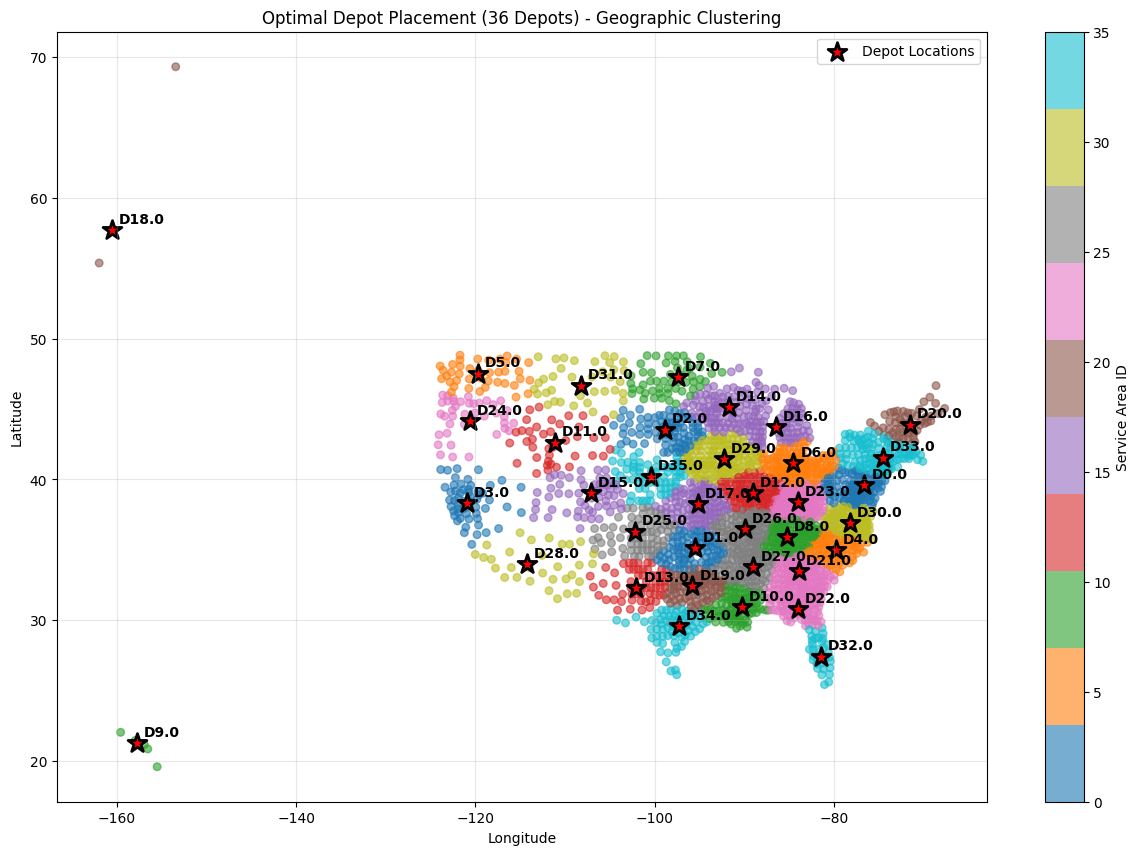

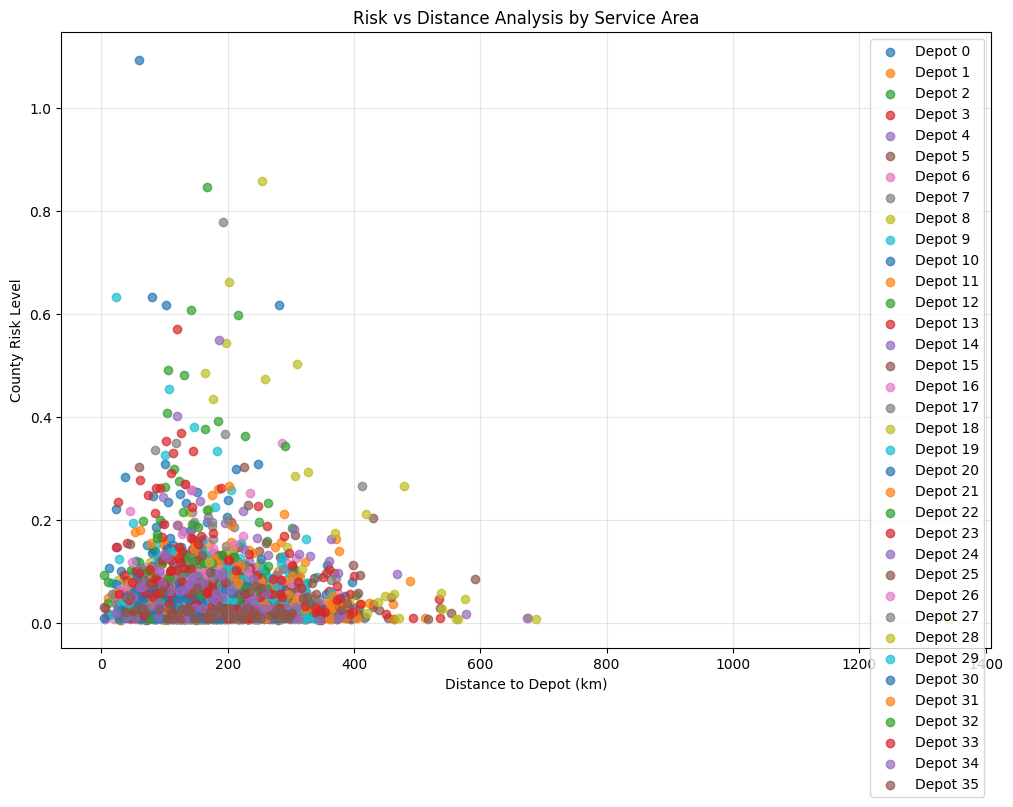


Model Summary:
- Created 36 strategic depot locations
- Average service radius: 180.0 km
- Maximum service distance: 1341.9 km
- Total counties served: 2738


In [ ]:
# Plot counties colored by service area
plt.figure(figsize=(15, 10))

scatter = plt.scatter(county_data_clean['longitude'], county_data_clean['latitude'], 
                        c=county_data_clean['depot_service_area'], 
                        cmap='tab10', alpha=0.6, s=30)

# Plot depot locations
plt.scatter(depot_df['longitude'], depot_df['latitude'], 
            c='red', marker='*', s=200, edgecolor='black', linewidth=2,
            label='Depot Locations')

# Annotate depot IDs
for _, depot in depot_df.iterrows():
    plt.annotate(f'D{depot["depot_id"]}', 
                (depot['longitude'], depot['latitude']),
                xytext=(5, 5), textcoords='offset points', fontweight='bold')

plt.colorbar(scatter, label='Service Area ID')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Optimal Depot Placement ({n_depots} Depots) - Geographic Clustering')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Step 8: Risk vs Distance Analysis
plt.figure(figsize=(12, 8))
for depot_id in range(n_depots):
    depot_data = service_stats_df[service_stats_df['depot_id'] == depot_id]
    plt.scatter(depot_data['distance_to_depot_km'], depot_data['county_risk'], 
                label=f'Depot {depot_id}', alpha=0.7)

plt.xlabel('Distance to Depot (km)')
plt.ylabel('County Risk Level')
plt.title('Risk vs Distance Analysis by Service Area')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nModel Summary:")
print(f"- Created {n_depots} strategic depot locations")
print(f"- Average service radius: {service_stats_df['distance_to_depot_km'].mean():.1f} km")
print(f"- Maximum service distance: {service_stats_df['distance_to_depot_km'].max():.1f} km")
print(f"- Total counties served: {len(county_data_clean)}")
